In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/Share/home/shibinbin/projects/DeepShape


In [6]:
import keras
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Lambda, Reshape
from keras.models import Model
from keras.layers.merge import Concatenate, Add
from keras.layers.convolutional import Conv1D, Conv2D, UpSampling1D, UpSampling2D
from keras.layers.pooling import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D, AveragePooling1D
from keras.regularizers import l2, l1, l1_l2
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.layers.recurrent import LSTM
from keras import backend as K

def set_keras_num_threads(n_threads):
    from keras import backend as K
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.intra_op_parallelism_threads = n_threads
    config.inter_op_parallelism_threads = n_threads
    K.set_session(tf.Session(config=config))
    
set_keras_num_threads(2)

In [119]:
import RNA
from forgi.graph import bulge_graph
from scipy.sparse import csr_matrix

In [27]:
alphabet = np.array(list('AUCG'))
sequences = np.take(alphabet, np.random.randint(4, size=(100, 60)))
sequences_str = [''.join(a) for a in sequences]

structures = []
energies = []
for seq in sequences_str:
    structure, energy = RNA.fold(seq)
    structures.append(structure)
    energies.append(energy)

In [114]:
def structure_to_adj_list(structure):
    '''
    Parameters:
        structure: str
            Dot-bracket representation of RNA secondary structure
    Returns:
        adj_list: list
            Each element is a list of tuples (node_index, edge_index)
        edge_data: array
            Shape: [length, 3]
            One-hot coding of edges
            10: adjacent connection
            01: base pair
    '''
    L = len(structure)
    adj_list = [[] for i in range(L)]
    edge_data = []
    S = []
    edge_index = 0
    for i in range(L):
        if i > 0:
            adj_list[i].append([i - 1, edge_index])
            adj_list[i - 1].append([i, edge_index])
            edge_data.append([1, 0])
            edge_index += 1
        if structure[i] == '(':
            S.append(i)
        elif structure[i] == ')':
            if len(S) == 0:
                raise ValueError('Extra ")" found in dot-bracket at position {}'.format(i))
            else:
                j = S.pop()
                adj_list[i].append([j, edge_index])
                adj_list[j].append([i, edge_index])
                edge_data.append([0, 1])
                edge_index += 1
    if len(S) != 0:
        raise ValueError('Extra "(" found in dot-bracket at position {}'.format(S[0]))
    edge_data = np.asarray(edge_data, dtype=np.int32)
    adj_list = [np.asarray(a, dtype=np.int32) for a in adj_list]
    
    return adj_list, edge_data

def graph_featurize(node_data, adj_lists, max_deg=3, digraph=False):
    '''
    Parameters:
        node_data: list
            Each element is an array of shape [length, n_channels]
            List length: n_samples
        adj_lists: list
            A list of tuples: (start_node, end_node)
            List length: n_samples
    Returns:
        node_features: list
            Copy from input argument node_data
        neighbor_features: list
            Each element is an array of shape [n_nodes_deg, deg]
            List length: max_deg + 1
        node_ranges: list
            Each element is an array of shape [n_samples, 2]
            node_ranges[i][j, 0]: start index of node j of degree i
            node_ranges[i][j, 1]: end index of node j of degree i
            List length: max_deg + 1
    '''
    n_samples = len(adj_lists)
    neighbor_features = [[] for i in range(max_deg + 1)]
    for i_sample in range(n_samples):
        neighbor_features_s = [[] for i in range(max_deg + 1)]
        for i_node, adj_nodes in enumerate(adj_lists[i_sample]):
            deg = len(adj_nodes)
            if deg > max_deg:
                raise ValueError('number of adjacent nodes of node {} in sample {} is larger than maximum degree {}'.format(
                    i_node, i_sample, max_deg))
            neighbor_features_s[deg].append(node_data[i_sample][adj_nodes])
        for deg in range(max_deg + 1):
            if len(neighbor_features_s[deg]) > 0:
                neighbor_features_s[deg] = np.row_stack(neighbor_features_s[deg])
            else:
                neighbor_features_s[deg] = np.empty((0, deg), dtype=np.int32)
            neighbor_features[deg].append(neighbor_features_s[deg])
    node_ranges = []
    for deg in range(max_deg + 1):
        node_ranges_d = np.empty((n_samples, 2), dtype=np.int32)
        n_nodes_deg = np.asarray([a.shape[0] for a in neighbor_features[deg]], dtype=np.int32)
        node_ranges_d[:, 1] = np.cumsum(n_nodes_deg)
        node_ranges_d[:, 0] = node_ranges_d[:, 1] - n_nodes_deg
        node_ranges.append(node_ranges_d)
        neighbor_features[deg] = np.concatenate(neighbor_features[deg], axis=0)
    r = {
        'node_features': node_data,
        'neighbor_features': neighbor_features,
        'node_ranges': node_ranges
    }
    return r

def graph_featurize(node_data, adj_lists, max_deg=3, digraph=False):
    '''
    Parameters:
        node_data: list
            Each element is an array of shape [length, n_channels]
            List length: n_samples
        edge_data: list
            Shape: [n_edges, n_channels_edge]
            List length: n_samples
        adj_lists: list
            adj_lists[i][j][0]: index of adjacent node j of node i in node_data[i]
            adj_lists[i][j][1]: index of edge (i, j) in edge_data[i]
            List length: n_samples
    Returns:
        node_features: array
            Shape: [n_nodes, n_channels]
        node_ranges: array
            Shape: [n_samples, 2]
            node_ranges[i, 0]: start index of sample i in node_features
            node_ranges[i, 1]: end index of sample i in node_features
        neighbor_indices: array
            Shape [n_nodes_deg*deg]*max_deg
            Indices of neighbor nodes of degree deg in node_features (first axis)
        neighbor_indices_ranges: array
            Shape: [max_deg, 2]
            neighbor_indices_ranges[deg, 0]: start index of degree deg in neighbor_indices
            neighbor_indices_ranges[deg, 1]: end index of degree deg in neighbor_indices
    '''
    n_samples = len(node_data)
    graph_sizes = np.asarray([len(a) for a in node_data], dtype=np.int32)
    node_features = np.concatenate(node_data, axis=0)
    
    node_ranges = np.zeros((n_samples, 2), dtype=np.int32)
    node_ranges[:, 1] = np.cumsum(graph_sizes)
    node_ranges[:, 0] = node_ranges[:, 1] - graph_sizes
    
    neighbor_indices = [[] for i in range(max_deg)]
    for i_sample in range(n_samples):
        neighbor_indices_s = [[] for i in range(max_deg)]
        for i_node, adj_nodes in enumerate(adj_lists[i_sample]):
            deg = len(adj_nodes)
            if deg > max_deg:
                raise ValueError('number of adjacent nodes of node {} in sample {} is larger than maximum degree {}'.format(
                    i_node, i_sample, max_deg))
            neighbor_indices_s[deg - 1].append(adj_nodes)
        for deg in range(max_deg):
            if len(neighbor_indices_s[deg]) > 0:
                neighbor_indices_s[deg] = np.concatenate(neighbor_indices_s[deg])
                neighbor_indices_s[deg] += node_ranges[i_sample, 0]
            else:
                neighbor_indices_s[deg] = np.empty(0, dtype=np.int32)
            neighbor_indices[deg].append(neighbor_indices_s[deg])
    for deg in range(max_deg):
        neighbor_indices[deg] = np.concatenate(neighbor_indices[deg])
    neighbor_indices_lengths = np.asarray([len(a) for a in neighbor_indices], dtype=np.int32)
    neighbor_indices_ranges = np.zeros((max_deg, 2), dtype=np.int32)
    neighbor_indices_ranges[:, 1] = np.cumsum(neighbor_indices_lengths)
    neighbor_indices_ranges[:, 0] = neighbor_indices_ranges[:, 1] - neighbor_indices_lengths
    neighbor_indices = np.concatenate(neighbor_indices)
    r = {
        'node_features': node_features,
        'node_ranges': node_ranges,
        'neighbor_indices': neighbor_indices,
        'neighbor_indices_ranges': neighbor_indices_ranges,
    }
    return r

sequence_str = sequences_str[0]
sequence = sequences[0]
structure = structures[0]
node_data = (sequence.reshape((-1, 1)) == alphabet.reshape((1, -1))).astype(np.int32)
print('Sequence:', sequence)
print('Structure:', structure)
adj_list = structure_to_adj_list(structure)
print(adj_list)

node_data = []
adj_lists = []
for i in range(3):
    node_data.append((sequences[i].reshape((-1, 1)) == alphabet.reshape((1, -1))).astype(np.int32))
    adj_lists.append(structure_to_adj_list(structures[i]))
graph_features = graph_featurize(node_data, adj_lists, max_deg=3)
for key, value in graph_features.items():
    print('{}: shape = {}'.format(key, value.shape))

Sequence: ['G' 'A' 'C' 'A' 'G' 'C' 'A' 'U' 'G' 'G' 'C' 'U' 'G' 'A' 'A' 'C' 'U' 'C'
 'A' 'C' 'U' 'U' 'U' 'C' 'A' 'A' 'C' 'G' 'C' 'G' 'G' 'A' 'A' 'C' 'U' 'C'
 'G' 'C' 'U' 'G' 'C' 'C' 'C' 'A' 'A' 'G' 'U' 'A' 'A' 'G' 'C' 'A' 'U' 'C'
 'C' 'C' 'C' 'A' 'G' 'U']
Structure: ..((((...))))..((.((((.....(((.....))).....)))).))..........
[[1], [0, 2], [1, 3, 12], [2, 4, 11], [3, 5, 10], [4, 6, 9], [5, 7], [6, 8], [7, 9], [8, 5, 10], [9, 4, 11], [10, 3, 12], [11, 2, 13], [12, 14], [13, 15], [14, 16, 49], [15, 17, 48], [16, 18], [17, 19, 46], [18, 20, 45], [19, 21, 44], [20, 22, 43], [21, 23], [22, 24], [23, 25], [24, 26], [25, 27], [26, 28, 37], [27, 29, 36], [28, 30, 35], [29, 31], [30, 32], [31, 33], [32, 34], [33, 35], [34, 29, 36], [35, 28, 37], [36, 27, 38], [37, 39], [38, 40], [39, 41], [40, 42], [41, 43], [42, 21, 44], [43, 20, 45], [44, 19, 46], [45, 18, 47], [46, 48], [47, 16, 49], [48, 15, 50], [49, 51], [50, 52], [51, 53], [52, 54], [53, 55], [54, 56], [55, 57], [56, 58], [57, 59], [58]]


In [115]:
for deg, node_ranges in enumerate(graph_features['node_ranges']):
    print('degree = {}'.format(deg))
    print(node_ranges)

degree = 0
[ 0 60]
degree = 1
[ 60 120]
degree = 2
[120 180]


In [116]:
for deg, neighbor_indices_range in enumerate(graph_features['neighbor_indices_ranges']):
    deg += 1
    start, end = neighbor_indices_range
    neighbor_indices_deg = graph_features['neighbor_indices'][start:end].reshape((-1, deg))
    print('degree = {}, shape = {}'.format(deg, neighbor_indices_deg.shape))

degree = 1, shape = (6, 1)
degree = 2, shape = (78, 2)
degree = 3, shape = (96, 3)


In [118]:
neighbor_indices_deg[:10]

array([[ 1,  3, 12],
       [ 2,  4, 11],
       [ 3,  5, 10],
       [ 4,  6,  9],
       [ 8,  5, 10],
       [ 9,  4, 11],
       [10,  3, 12],
       [11,  2, 13],
       [14, 16, 49],
       [15, 17, 48]])

In [ ]:
class Lambda(Layer):
    """Wraps arbitrary expression as a `Layer` object.

    # Examples

    ```python
        # add a x -> x^2 layer
        model.add(Lambda(lambda x: x ** 2))
    ```
    ```python
        # add a layer that returns the concatenation
        # of the positive part of the input and
        # the opposite of the negative part

        def antirectifier(x):
            x -= K.mean(x, axis=1, keepdims=True)
            x = K.l2_normalize(x, axis=1)
            pos = K.relu(x)
            neg = K.relu(-x)
            return K.concatenate([pos, neg], axis=1)

        def antirectifier_output_shape(input_shape):
            shape = list(input_shape)
            assert len(shape) == 2  # only valid for 2D tensors
            shape[-1] *= 2
            return tuple(shape)

        model.add(Lambda(antirectifier,
                         output_shape=antirectifier_output_shape))
    ```

    # Arguments
        function: The function to be evaluated.
            Takes input tensor as first argument.
        output_shape: Expected output shape from function.
            Only relevant when using Theano.
            Can be a tuple or function.
            If a tuple, it only specifies the first dimension onward;
                 sample dimension is assumed either the same as the input:
                 `output_shape = (input_shape[0], ) + output_shape`
                 or, the input is `None` and
                 the sample dimension is also `None`:
                 `output_shape = (None, ) + output_shape`
            If a function, it specifies the entire shape as a function of the
            input shape: `output_shape = f(input_shape)`
        arguments: optional dictionary of keyword arguments to be passed
            to the function.

    # Input shape
        Arbitrary. Use the keyword argument input_shape
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.

    # Output shape
        Specified by `output_shape` argument
        (or auto-inferred when using TensorFlow).
    """

    @interfaces.legacy_lambda_support
    def __init__(self, function, output_shape=None,
                 mask=None, arguments=None, **kwargs):
        super(Lambda, self).__init__(**kwargs)
        self.function = function
        self.arguments = arguments if arguments else {}
        if mask is not None:
            self.supports_masking = True
        self.mask = mask

        if output_shape is None:
            self._output_shape = None
        elif isinstance(output_shape, (tuple, list)):
            self._output_shape = tuple(output_shape)
        else:
            if not callable(output_shape):
                raise TypeError('In Lambda, `output_shape` '
                                'must be a list, a tuple, or a function.')
            self._output_shape = output_shape

    def compute_output_shape(self, input_shape):
        if self._output_shape is None:
            # With TensorFlow, we can infer the output shape directly:
            if K.backend() == 'tensorflow':
                if isinstance(input_shape, list):
                    xs = [K.placeholder(shape=shape) for shape in input_shape]
                    x = self.call(xs)
                else:
                    x = K.placeholder(shape=input_shape)
                    x = self.call(x)
                if isinstance(x, list):
                    return [K.int_shape(x_elem) for x_elem in x]
                else:
                    return K.int_shape(x)
            # Otherwise, we default to the input shape.
            warnings.warn('`output_shape` argument not specified for layer {} '
                          'and cannot be automatically inferred '
                          'with the Theano backend. '
                          'Defaulting to output shape `{}` '
                          '(same as input shape). '
                          'If the expected output shape is different, '
                          'specify it via the `output_shape` argument.'
                          .format(self.name, input_shape))
            return input_shape
        elif isinstance(self._output_shape, (tuple, list)):
            if isinstance(input_shape, list):
                num_samples = input_shape[0][0]
            else:
                num_samples = input_shape[0] if input_shape else None
            return (num_samples,) + tuple(self._output_shape)
        else:
            shape = self._output_shape(input_shape)
            if not isinstance(shape, (list, tuple)):
                raise ValueError('`output_shape` function must return a tuple or a list of tuples.')
            if isinstance(shape, list):
                if isinstance(shape[0], int) or shape[0] is None:
                    shape = tuple(shape)
            return shape

    def call(self, inputs, mask=None):
        arguments = self.arguments
        if has_arg(self.function, 'mask'):
            arguments['mask'] = mask
        return self.function(inputs, **arguments)

    def compute_mask(self, inputs, mask=None):
        if callable(self.mask):
            return self.mask(inputs, mask)
        return self.mask

    def get_config(self):
        if isinstance(self.function, python_types.LambdaType):
            function = func_dump(self.function)
            function_type = 'lambda'
        else:
            function = self.function.__name__
            function_type = 'function'

        if isinstance(self._output_shape, python_types.LambdaType):
            output_shape = func_dump(self._output_shape)
            output_shape_type = 'lambda'
        elif callable(self._output_shape):
            output_shape = self._output_shape.__name__
            output_shape_type = 'function'
        else:
            output_shape = self._output_shape
            output_shape_type = 'raw'

        config = {'function': function,
                  'function_type': function_type,
                  'output_shape': output_shape,
                  'output_shape_type': output_shape_type,
                  'arguments': self.arguments}
        base_config = super(Lambda, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config, custom_objects=None):
        config = config.copy()
        globs = globals()
        if custom_objects:
            globs = dict(list(globs.items()) + list(custom_objects.items()))
        function_type = config.pop('function_type')
        if function_type == 'function':
            # Simple lookup in custom objects
            function = deserialize_keras_object(
                config['function'],
                custom_objects=custom_objects,
                printable_module_name='function in Lambda layer')
        elif function_type == 'lambda':
            # Unsafe deserialization from bytecode
            function = func_load(config['function'], globs=globs)
        else:
            raise TypeError('Unknown function type:', function_type)

        output_shape_type = config.pop('output_shape_type')
        if output_shape_type == 'function':
            # Simple lookup in custom objects
            output_shape = deserialize_keras_object(
                config['output_shape'],
                custom_objects=custom_objects,
                printable_module_name='output_shape function in Lambda layer')
        elif output_shape_type == 'lambda':
            # Unsafe deserialization from bytecode
            output_shape = func_load(config['output_shape'], globs=globs)
        else:
            output_shape = config['output_shape']

        # If arguments were numpy array, they have been saved as
        # list. We need to recover the ndarray
        if 'arguments' in config:
            for key in config['arguments']:
                if isinstance(config['arguments'][key], dict):
                    arg_dict = config['arguments'][key]
                    if 'type' in arg_dict and arg_dict['type'] == 'ndarray':
                        # Overwrite the argument with its numpy translation
                        config['arguments'][key] = np.array(arg_dict['value'])

        config['function'] = function
        config['output_shape'] = output_shape
        return cls(**config)




In [ ]:
class GraphConv(Layer):
    def __init__(self, units, max_deg, 
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(Dense, self).__init__(**kwargs)
        self.units = units
        self.max_deg = max_deg
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = False

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        # kernel[0 - max_deg]: kernel for neighbor nodes
        # kernel[max_deg + 1]: kernel for node itself
        self.kernel = self.add_weight(shape=(self.max_deg + 2, input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        node_features, neighbor_features, neighbor_ranges = inputs
        summed_outputs = []
        for deg in range(self.max_deg + 1):
            summed_outputs.append(K.sum(neighbor_features[deg], axis=-1))
        summed_outputs.append(node_features)
        output = K.concatenate(summed_outputs, axis=1)
        output = K.dot(output, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(Dense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



In [85]:
import types
import marshal
import codecs

In [78]:
def func_dump(func):
    """Serializes a user defined function.

    # Arguments
        func: the function to serialize.

    # Returns
        A tuple `(code, defaults, closure)`.
    """
    raw_code = marshal.dumps(func.__code__)
    code = codecs.encode(raw_code, 'base64').decode('ascii')
    defaults = func.__defaults__
    if func.__closure__:
        closure = tuple(c.cell_contents for c in func.__closure__)
    else:
        closure = None
    return code, defaults, closure



In [88]:
print(codecs.encode(marshal.dumps(graph_featurize.__code__), 'base64').decode('ascii'))

4wQAAAAAAAAADwAAAAcAAABDAAAAc7ABAAB0AHwBgwF9BGQBZAKEAHQBfAJkAxcAgwFEAIMBfQV4
3HQBfASDAUQAXdB9BmQEZAKEAHQBfAJkAxcAgwFEAIMBfQd4UHQCfAF8BhkAgwFEAF1AXAJ9CH0J
dAB8CYMBfQp8CnwCawRyenQDZAVqBHwIfAZ8AoMDgwGCAXwHfAoZAGoFfAB8BhkAfAkZAIMBAQBx
UFcAeGJ0AXwCZAMXAIMBRABdUn0KdAB8B3wKGQCDAWQGawRyynQGagd8B3wKGQCDAXwHfAo8AG4Y
dAZqCGQGfApmAnQGaglkB40CfAd8CjwAfAV8ChkAagV8B3wKGQCDAQEAcaJXAHEoVwBnAH0LeJ50
AXwCZAMXAIMBRABdjn0KdAZqCHwEZAhmAnQGaglkB40CfQx0BmoKZAlkAoQAfAV8ChkARACDAXQG
aglkB40CfQ10BmoLfA2DAXwMZApkCoUCZANmAjwAfAxkCmQKhQJkA2YCGQB8DRgAfAxkCmQKhQJk
BmYCPAB8C2oFfAyDAQEAdAZqDHwFfAoZAGQGZAuNAnwFfAo8AJABcQ5XAHwAfAV8C2QMnAN9DnwO
UwApDeHjAgAACiAgICBQYXJhbWV0ZXJzOgogICAgICAgIG5vZGVfZGF0YTogbGlzdAogICAgICAg
ICAgICBFYWNoIGVsZW1lbnQgaXMgYW4gYXJyYXkgb2Ygc2hhcGUgW2xlbmd0aCwgbl9jaGFubmVs
c10KICAgICAgICAgICAgTGlzdCBsZW5ndGg6IG5fc2FtcGxlcwogICAgICAgIGFkal9saXN0czog
bGlzdAogICAgICAgICAgICBBIGxpc3Qgb2YgdHVwbGVzOiAoc3RhcnRfbm9kZSwgZW5kX25vZGUp
CiAgICAgICAgICAgIExpc3QgbGVuZ3RoOiBuX3NhbXBsZXMKICAgIFJldHVybnM6CiAgICAgICAg

In [122]:
adj_list[:5]

[[1], [0, 2], [1, 3, 12], [2, 4, 11], [3, 5, 10]]

In [123]:
csr_matrix?

In [135]:
indices = np.concatenate(adj_list)
data = np.ones(len(indices), dtype=np.int32)
lengths = np.asarray(list(map(len, adj_list)), dtype=np.int32)
indptr = np.cumsum(lengths) - lengths
g = csr_matrix((data, indices, indptr))

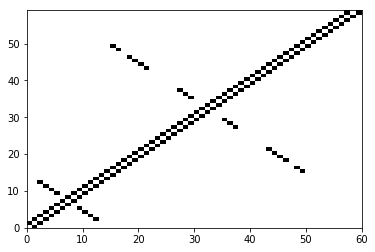

In [136]:
plt.pcolor(g.toarray(), cmap=cm.Greys)

In [142]:
(4*3 + 26*4*5 + 26*26*8)//2

2970